In [1]:
%matplotlib notebook

In [14]:
import numpy as np
from readts import TSFile
import matplotlib.pyplot as plt

In [18]:
tsf = TSFile('CuVacMorse', path='cuvac-neb-morse')
tst = tsf.blocks['TST']

In [19]:
max_step = tst.last_index
print('Converged in {0} iterations'.format(max_step))

In [23]:
E = tst.get_energies(max_step)
E -= E[0]
rc = tst.get_rcoords(max_step)

<IPython.core.display.Javascript object>


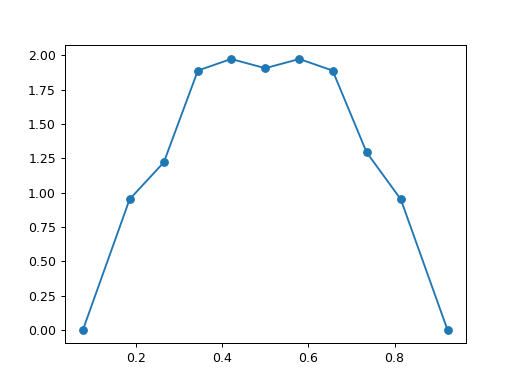

In [24]:
fig, ax = plt.subplots()

ax.plot(rc, E, 'o-')